In [1]:
import pandas as pd
import time
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
def read_indianPines():
    Indian_X = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
    Indian_Y = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
    #print(f"X shape: {X.shape}\ny shape: {y.shape}")
    return Indian_X, Indian_Y    

In [3]:
def bands_separation(bands, datasetX, datasetY):
    
    #Read data
    data_X = datasetX
    data_Y = datasetY
    
    data_X_selected = data_X[:,:,bands]

    print(data_X_selected.shape)

    #data dimensions
    x, y, z = data_X_selected.shape

    #reshapes arrays to have all data of each matrix into vectors
    data_X2d = data_X_selected.reshape((x * y, z))
    data_Y2d = data_Y.reshape((x * y, 1))

In [4]:
def extract_pixels(X, y):
    q = X.reshape(-1, X.shape[2])
    df = pd.DataFrame(data = q)
    df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
    df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
    #df.to_csv('Dataset.csv')
    return df

In [9]:
#Reading data from HBS algorithms
def HBS_bands():
    bands_FDPC = loadmat('SelectedBandsOCF.mat')['band_FDPC']

    bands_NC_IE = loadmat('SelectedBandsOCF.mat')['band_NC_IE']

    bands_simil = loadmat('SelectedSBS.mat')['bands_simil']

    bands_svd = loadmat('SelectedSBS.mat')['bands_svd']

    bands_EGCSR = np.load("bands_EGCSR.npy").astype(int) + 1
    
    bands_bombs = np.load("bands_bombs.npy").astype(int)

    #nonzeroind = np.nonzero(bands_svd)[0] # the return is a little funny so I use the [0]
    #print(nonzeroind)


    bands = {
        "FDPC" : bands_FDPC,
        "NC_IR" : bands_NC_IE,
        "simil" : bands_simil,
        "svd" : bands_svd,
        "EGCSR" : bands_EGCSR,
        "bombs": bands_bombs
    }
    
    return bands
    

#for k in bands:        
#    x,y = bands[k].shape
    
#    for i in range(x):
        
#        print(k, "selection for: ", (i+1)*8," bands is: ", bands[k][i,:(i+1)*8],"\n")


In [10]:
#MAIN 2
def HBS_classif(X_Itrain, y_Itrain, X_Itest):
    #Creates Svm Clasiffier
    indian_classifier = svm.SVC(C = 120, kernel = 'rbf', cache_size = 10*1024)

    #Train the model using the training sets
    indian_classifier.fit(X_Itrain, y_Itrain.ravel())

    #Prediction of test set using trained model
    indian_pred = indian_classifier.predict(X_Itest)
    
    return indian_pred

In [11]:
#MAIN 

#Reads selected number of bands for different algorithms into a dictionary
bands = HBS_bands()

HBS_predictions = {}

HBS_accuracy = {}

#name of classes for indian pines
names = ['Alfalfa','Corn-notill', 'Corn-mintill','Corn','Grass-pasture','Grass-trees',
'Grass-pasture-mowed','Hay-windrowed','Oats','Soybean-notill','Soybean-mintill',
'Soybean-clean', 'Wheat','Woods','Buildings Grass Trees Drives','Stone Steel Towers'] 
    
#Iterates over bands sets 
for k in bands:        
    x,y = bands[k].shape
    
    for i in range(x):
        
        b_count = (i+1)*8
        
        #reads indian dataset
        indian_X,indian_Y = read_indianPines()
        #takes selected bands from indian dataset
        indian_X_selected = indian_X[:,:,bands[k][i,:b_count]-1]

        #print for confirmation
        print("Processing: ", k, b_count)

        #data dimensions
        x, y, b = indian_X_selected.shape
        
        ####data to pandas dataframe
        data_indian = extract_pixels(indian_X_selected, indian_Y)

        #cleaning data
        data_x = data_indian[data_indian['class'] != 0]
        indian_X2d = data_x.iloc[:, :-1].values
        indian_Y2d = data_x.loc[:, 'class'].values 

        # Split dataset into training set and test set
        X_train, X_test, y_train, y_test = train_test_split(indian_X2d, indian_Y2d,
                                                            test_size=0.7, random_state=11, stratify=indian_Y2d)
        
        #Creates Svm Clasiffier
        indian_classifier = svm.SVC(C = 120, kernel = 'rbf', cache_size = 10*1024)

        #Train the model using the training sets
        indian_classifier.fit(X_train, y_train.ravel())

        #Prediction of test set using trained model
        HBS_predictions[str(k) + "_pred_" + str(b_count)] = indian_classifier.predict(X_test)   
        
        for n in HBS_predictions:        
    
            accuracy = metrics.accuracy_score(y_test, HBS_predictions[n])
            
            HBS_accuracy[str(k) + "_acc_" + str(b_count)] = accuracy
   

Processing:  FDPC 8
Processing:  FDPC 16
Processing:  FDPC 24
Processing:  FDPC 32
Processing:  NC_IR 8
Processing:  NC_IR 16
Processing:  NC_IR 24
Processing:  NC_IR 32
Processing:  simil 8
Processing:  simil 16
Processing:  simil 24
Processing:  simil 32
Processing:  svd 8
Processing:  svd 16
Processing:  svd 24
Processing:  svd 32
Processing:  EGCSR 8
Processing:  EGCSR 16
Processing:  EGCSR 24
Processing:  EGCSR 32
Processing:  bombs 8
Processing:  bombs 16
Processing:  bombs 24
Processing:  bombs 32


In [13]:
###Classification results

for a in HBS_accuracy:     
    
    print(a, " accuracy is " ,HBS_accuracy[a])
    
np.save("HBS_predictions", HBS_predictions)
np.save("HBS_accuracy", HBS_accuracy)

FDPC_acc_8  accuracy is  0.7245993031358885
FDPC_acc_16  accuracy is  0.74801393728223
FDPC_acc_24  accuracy is  0.7598606271777003
FDPC_acc_32  accuracy is  0.7593031358885017
NC_IR_acc_8  accuracy is  0.7421602787456446
NC_IR_acc_16  accuracy is  0.7453658536585366
NC_IR_acc_24  accuracy is  0.7701742160278746
NC_IR_acc_32  accuracy is  0.7820209059233449
simil_acc_8  accuracy is  0.7275261324041812
simil_acc_16  accuracy is  0.7774216027874564
simil_acc_24  accuracy is  0.7859233449477352
simil_acc_32  accuracy is  0.787595818815331
svd_acc_8  accuracy is  0.7193031358885017
svd_acc_16  accuracy is  0.7892682926829269
svd_acc_24  accuracy is  0.7998606271777003
svd_acc_32  accuracy is  0.802787456445993
EGCSR_acc_8  accuracy is  0.6316376306620209
EGCSR_acc_16  accuracy is  0.7432752613240418
EGCSR_acc_24  accuracy is  0.7347735191637631
EGCSR_acc_32  accuracy is  0.7554006968641115
bombs_acc_8  accuracy is  0.5368641114982579
bombs_acc_16  accuracy is  0.6893379790940767
bombs_acc_

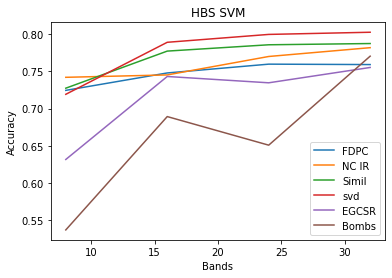

In [16]:
x = np.array([8,16,24,32])

a = np.zeros(4)
b = np.zeros(4)
c = np.zeros(4)
d = np.zeros(4)
e = np.zeros(4)
f = np.zeros(4)

for i in range(4):
    
    b_count = (i+1)*8
    
    a[i] = HBS_accuracy["FDPC_acc_" + str(b_count)]
    b[i] = HBS_accuracy["NC_IR_acc_" + str(b_count)]
    c[i] = HBS_accuracy["simil_acc_" + str(b_count)]
    d[i] = HBS_accuracy["svd_acc_" + str(b_count)]
    e[i] = HBS_accuracy["EGCSR_acc_" + str(b_count)]
    f[i] = HBS_accuracy["bombs_acc_" + str(b_count)]
    
    
plt.plot(x, a, label='FDPC')  
plt.plot(x, b, label='NC IR')  
plt.plot(x, c, label='Simil')
plt.plot(x, d, label='svd') 
plt.plot(x, e, label='EGCSR') 
plt.plot(x, f, label='Bombs')

plt.xlabel('Bands')
plt.ylabel('Accuracy')
plt.title("HBS SVM")
plt.legend()

In [ ]:
#Classification visualization

#name of classes
names = ['Alfalfa','Corn-notill', 'Corn-mintill','Corn','Grass-pasture','Grass-trees',
'Grass-pasture-mowed','Hay-windrowed','Oats','Soybean-notill','Soybean-mintill',
'Soybean-clean', 'Wheat','Woods','Buildings Grass Trees Drives','Stone Steel Towers']

#creation of dataframe for results visualization using confusion matrix
indian_confusion = metrics.confusion_matrix(y_Itest, indian_pred)
df_I = pd.DataFrame(indian_confusion, columns=np.array(names), index = np.array(names))
df_I.index.name = 'Real'
df_I.columns.name = 'Predicted'

#Figure properties 
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size

#figure ploting
sn.heatmap(df_I, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')

#classification report
print(metrics.classification_report(y_Itest, indian_pred, target_names = names))

In [ ]:
#Classification map prediction

l=[]
for i in range(data_indian.shape[0]):
    #this if statement ignore class 0 for the classification. Coloring it black in image.
    if data_indian.iloc[i, -1] == 0:
        l.append(0)
    else:
        l.append(indian_classifier.predict(data_indian.iloc[i, :-1].values.reshape(1, -1)))

In [ ]:
#Classification map visualization
clmap = np.array(l).reshape(145, 145).astype('float')
plt.figure(figsize=(10, 8))
plt.imshow(clmap, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_cmap.png')
plt.show()